# Zernike 3D 


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from mayavi import mlab
from scipy.special import sph_harm
from math import factorial as fact
from math import pi, sqrt, sin, cos, atan2


def binomial(n, k): return fact(n)  / (fact(k) * fact(n - k))

In [92]:
class Zernike3D:
    def __init__(self, IMG3D: np.array):
        self.IMG3D = IMG3D

    def radial(self, n: int, l: int) -> ():
        """Radial Zernike polynomials normalized for 3D case for given order n, l."""
        # normalization factor
        Q = lambda k, l, nu: ((-1)**(k + nu) / 4**k) *\
                             sqrt((2 * l + 4 * k + 3) / 3) *\
                             (binomial(2 * k, k) * binomial(k, nu) * binomial(2 * (k + l + nu) + 1, 2 * k) / binomial(k + l + nu, k))
        if (n - l) % 2 != 0: 
            return lambda r: 0
        else:
            return lambda r: sum([Q((n - l) / 2, l, nu) * r**(2 * nu + l) for nu in range((n - l) // 2 + 1)]) 
    
    def zfunction(self, n: int, l: int, m: int) -> ():
        """Zernike 3D function of given order n, l, m."""
        # check parameters validity
        # init radial part
        R = self.radial(abs(n), abs(l))
        # 3D Zernike function
        def Z(x, y, z) -> ():
            if x**2 + y**2 + z**2 > 1:
                return 0
            else:
                r = sqrt(x**2 + y**2 + z**2)
                theta = atan2(sqrt(x**2 + y**2), z)
                phi = atan2(y, x)
                return  R(r) * sph_harm(m, l, phi, theta)
        return Z

    def zfunction_on_grid(self, n: int, l: int, m: int) -> np.array:
        """Calculate 3D Zernike function on the grid with shape of the given 3D image."""
        # discretization parameters
        max_x, max_y, max_z = self.IMG3D.shape[:3]
        dx, dy, dz = 2 / (max_x - 1), 2 / (max_y - 1), 2 / (max_z - 1)
        x, y, z = np.arange(-1, 1 + dx, dx), np.arange(-1, 1 + dy, dy), np.arange(-1, 1 + dz, dz) 
        Z = self.zfunction(n, l, m)
        Z_on_grid = np.array([[[np.real(Z(xi, yi, zi)) for xi in x] for yi in y] for zi in z])
        return Z_on_grid

    def descriptor(self, n: int) -> list:
        """Zernike 3D descriptor vector of given order for 3D image."""
        # determine the Zernike functions on the grid of the given 3D image
        # excluding points with zero x, y, z uncertainty 0 / 0 or inf / 0
        vector = []
        # calculate the normalization factor: number of pixels in the unit sphere, i.e. mode 0,0,0
        norm_factor = np.sum(np.real(self.zfunction_on_grid(0,0,0)))
        # calculate allowed modes for given n
        allowed_modes = [(0,0,0), (1,1,0), (1,1,1), (2,0,0), (2, 2, 1), (3,1,1), (4,0,0), (4, 2, 0), (4, 2, 1), (4, 2, -1), (4,2,2)]

        for ni, li, mi in allowed_modes:
            # calculation of the 3D Zernike function on the grid 
            A = self.zfunction_on_grid(ni, li, mi) # <- most computationally comlex part
            component = np.sum(A * self.IMG3D) / norm_factor
            vector.append((ni, li, mi, component))
        return vector

    def plot_radial(self, n: int, l: int):
        """Plot radial Zernike polynom of order n."""
        R = self.radial(n, l)
        x = np.arange(0, 1, 0.01)
        y = np.array([R(r) for r in x])

        plt.figure(dpi=100)
        plt.plot(x, y)
        plt.xlim(0, 1.1)
        plt.ylabel(f'$R_{n}^{l}(r)$')
        plt.xlabel('r')
        plt.show()

    def plot_moment_slice(self, n: int, l: int, m: int, lattitude: int=1):
        """Plot 3D Zernike moment slice at the level lattitude * grid_step."""
        Z = self.zfunction(n, l, m)
        d = 0.01
        x = np.concatenate([np.arange(-1, -d, d), np.arange(d, 1 + d, d)])
        cut_const_z = np.array([[np.real(Z(xi, yi, lattitude * d)) for xi in x] for yi in x])
        cut_const_x = np.array([[np.real(Z(lattitude * d, yi, zi)) for zi in x] for yi in x])

        plt.figure(dpi=100)
        plt.subplot(1,2,1)
        plt.imshow(cut_const_z, cmap='rainbow')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        plt.title('xy')

        plt.subplot(1,2,2)
        plt.imshow(cut_const_x, cmap='rainbow')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        plt.title('zy')
        plt.show()

    def plot_moment_3d(self, n: int, l: int, m: int):
        """Plot 3D zernike moment in 3D as density plot."""
        # calculate 3D Zernike function on the grid
        mode = self.zfunction_on_grid(n, l, m) 
        mode = np.abs(mode)
        # mode[mode != 0] +=  np.abs(np.min(mode))
        
        mlab.pipeline.volume(mlab.pipeline.scalar_field(mode), vmin=0, vmax=0.8 * np.max(mode))
        # mlab.pipeline.volume(mlab.pipeline.scalar_field(mode), vmin=np.min(mode), vmax=-0.1)
        # mlab.pipeline.volume(mlab.pipeline.scalar_field(self.IMG3D))
        mlab.axes()
        mlab.show()

def make_3D_img_from_spheres(spheres, ds=0.1):
    """Make 3D image from spheres: (x,y,z,r)."""
    smpl = np.arange(-1, 1 + ds, ds)
    N = smpl.shape[0]
    print(N)
    grid = np.zeros((N, N, N))

    for xi, yi, zi, ri in spheres:
        for i, x in enumerate(smpl):
            for j, y in enumerate(smpl):
                for k, z in enumerate(smpl):
                    if (x - xi)**2 + (y - yi)**2 + (z - zi)**2 <= ri**2:
                        grid[i,j,k] = 1
    
    return grid

41


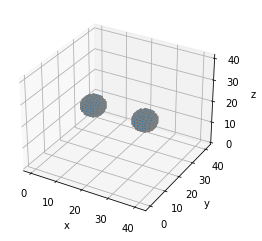

In [21]:
test_structure =  [(0.5, 0, 0, 0.2), (-0.5, 0, 0, 0.2)] # [(0, 0, 0, 0.2)]
test_3d_image = make_3D_img_from_spheres(test_structure, ds=0.05)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.voxels(test_3d_image, edgecolors='gray', shade=False)
plt.show()



In [93]:
zen = Zernike3D(test_3d_image)

#zen.plot_radial(1, 1)

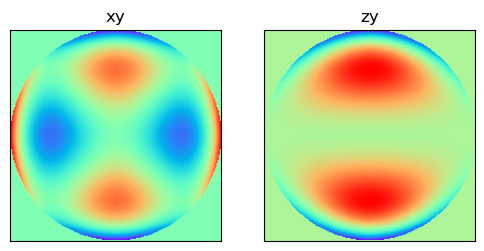

In [94]:
zen.plot_moment_slice(4, 2, 2, 1)


In [110]:
zen.plot_moment_3d(5,5,5)


In [40]:
zen.descriptor(2)


[(0, 0, 0, 0.015218693828639903),
 (1, 1, 0, -2.6795302306737694e-05),
 (1, 1, 1, 1.894713996503846e-05),
 (2, 0, 0, -0.019002542014483825),
 (2, 2, 1, -3.2423621673111314e-20),
 (3, 1, 1, -3.7749079810456774e-05),
 (4, 0, 0, 0.0039125866113735005),
 (4, 2, 0, -0.03475068974403455),
 (4, 2, 1, 2.1222734186036495e-19),
 (4, 2, -1, -1.3558969063301095e-19),
 (4, 2, 2, 2.947601970282847e-20)]

In [41]:
mlab.pipeline.volume(mlab.pipeline.scalar_field(test_3d_image))
mlab.axes()
mlab.show()

In [310]:
from scipy import stats

mu, sigma = 0, 0.1 
x = 10*np.random.normal(mu, sigma, 5000)
y = 10*np.random.normal(mu, sigma, 5000)    
z = 10*np.random.normal(mu, sigma, 5000)

xyz = np.vstack([x,y,z])
kde = stats.gaussian_kde(xyz)

# Evaluate kde on a grid
xmin, ymin, zmin = x.min(), y.min(), z.min()
xmax, ymax, zmax = x.max(), y.max(), z.max()
xi, yi, zi = np.mgrid[xmin:xmax:30j, ymin:ymax:30j, zmin:zmax:30j]
coords = np.vstack([item.ravel() for item in [xi, yi, zi]]) 
density = kde(coords).reshape(xi.shape)

print(xi[0][0])
print(density[0][0])

# Plot scatter with mayavi
figure = mlab.figure('DensityPlot')

grid = mlab.pipeline.scalar_field(xi, yi, zi, density)
min = density.min()
max=density.max()
mlab.pipeline.volume(grid, vmin=min, vmax=min + .5*(max-min))

mlab.axes()
mlab.show()

[-3.74674248 -3.74674248 -3.74674248 -3.74674248 -3.74674248 -3.74674248
 -3.74674248 -3.74674248 -3.74674248 -3.74674248 -3.74674248 -3.74674248
 -3.74674248 -3.74674248 -3.74674248 -3.74674248 -3.74674248 -3.74674248
 -3.74674248 -3.74674248 -3.74674248 -3.74674248 -3.74674248 -3.74674248
 -3.74674248 -3.74674248 -3.74674248 -3.74674248 -3.74674248 -3.74674248]
[2.12777924e-30 1.78475241e-28 1.37625964e-26 9.28793218e-25
 4.39884046e-23 1.17233687e-21 1.60186884e-20 1.09218769e-19
 3.70823338e-19 7.90560579e-19 8.42084040e-18 1.89383274e-16
 2.55518661e-15 2.11320637e-14 1.08853845e-13 3.26565429e-13
 5.26836185e-13 4.35528053e-13 1.80916966e-13 3.88244919e-14
 6.54682169e-15 2.42211686e-15 8.95695015e-16 1.75864513e-16
 1.71444169e-17 8.26207949e-19 1.96770029e-20 2.31592253e-22
 1.34705142e-24 3.87203627e-27]


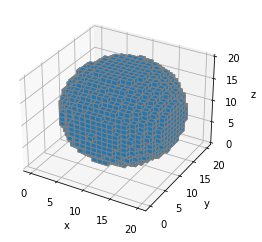

In [14]:
from mpl_toolkits.mplot3d import Axes3D

def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    return ax

def sphere(x, y, z):
    if x**2 + y**2 + z**2 <= 1:
        return 1
    else:
        return 0

filled = np.array([[[sphere(i, j, k) for i in np.arange(-1, 1, 0.1)] for j in np.arange(-1, 1, 0.1)] for k in np.arange(-1, 1, 0.1)])

ax = make_ax(True)
ax.voxels(filled, edgecolors='gray', shade=False)
plt.show()


In [283]:
d = 0.05
x = np.arange(-1, 1 + d, d)

A00 = np.array([[[np.real(zen.moment(0, 0, 0)(xi, yi, zi)) for xi in x] for yi in x] for zi in x])
NA00 = np.sum(A00)

print(NA00)

9416.324149412052


In [284]:
print(3 * (NA00 / (len(x)/2)**3) / 4)

0.8197493492037595


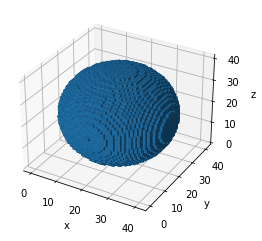

In [282]:
ax = make_ax(True)
ax.voxels(A00)
# ax.voxels(np.array([[[zen.moment(15, 3, 3)(xi, yi, zi) for xi in x] for yi in x] for zi in x]), edgecolors='gray', shade=False)
plt.show()

In [289]:
np.sum(A00 * A00) # NA00

2656.2960002037325

In [271]:
print(np.sum(A00))
print(NA00)

1174.3606181546547
4163


In [286]:
print(A00[1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [373]:
from time import time 

def timeit(f):
    def wrap(*args, **kargs):
        t1 = time()
        res = f(*args, **kargs)
        t2 = time()
        print(f'{f.__name__} func. took:\t{round((t2 - t1), 6)} s')
        return res
    return wrap
    